# Assessing Neural Networks

Now that we've gotten our basic neural network model working, we want to know how good the model is. This notebook covers a few tools that we can use to assess a neural network.

## Table of Contents

* [Training and Assessment Procedure](#training)
* [Baseline Keras Model Architecture: The SeattleModel](#seattle)
* [Keras Callbacks to Assess Accuracy](#callbacks)
    * [TensorBoard](#tensorboard)
    * [Loss History](#loss-history)
* [Summary](#summary)

<a name="training"></a>
## Training and Assessment Procedure

The basic procedure we follow for training and assessing a neural network model looks like this:

* Create a model architecture and set model parameters
* Load the data from fuel
* Clean the data
* Create model callbacks (TensorFlow, loss history, etc.)
* Train the model
* Assess model performance

This cycle is repeated as the model architectures are tweaked and improved. The iterative process of repeating these steps is the hyperparameter optimization procedure.

<a name="seattle"></a>
## Baseline Keras Model Architecture: The Seattle Model

Our baseline model architecture will be the Seattle model. This is the very simple convolutional neural network we saw in Notebook 3. 

As model architectures get more complicated and add addiitonal layers, they will be named after cities that move progressively eastward. (Reno, Phoenix, Yellowstone, Denver, Omaha, etc). The architecture refers only to the arrangement of different layers, and does not specify the size of each layer. So you might have a very simple architecture with many, many neurons in a given layer (requiring more time to train), or you might have a very complicated architecture with very few neurons in a given layer (making training much faster).

We've broken out the creation of the Keras model into a function in `models.py`, and we've put the cropping and downsampling function into a function in `clean.py`.

In [1]:
%matplotlib inline
import numpy as np

from lfw_fuel import lfw
from models import seattle_model
from clean import clean

modelA = seattle_model() # Use all the defaults. This already calls compile().

Using TensorFlow backend.


In [2]:
print(modelA.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4832      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

We'll also load the data, just so we've got it ready to go.

In [3]:
# Load the data, shuffled and split between train and test sets
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = lfw.load_data("deepfunneled")

In [4]:
(X_train, y_train), (X_test, y_test) = clean(X_train_orig, y_train_orig, X_test_orig, y_test_orig)

<a name="callbacks"></a>
## Keras Callbacks to Assess Accuracy

We'll look at two callbacks:

* TensorBoard (built-in callback)
* Loss History (custom callback)

<a name="tensorboard"></a>
### TensorBoard

If we are using the TensorFlow backend for Keras, the TensorBoard callback allows us to dump out the status of the training at each step, and monitor the training through a fancy web interface.

The TensorBoard callback just dumps out information about the training process that TensorBoard can read - it does not actually start TensorBoard. To run TensorBoard, start it from the command line like this:

```
$ tensorboard --logdir=logs/
```

(where `logs/` is the directory specified by the `log_dir` arugment below). Then open the browser to `localhost:6006`.

In [5]:
from keras.callbacks import TensorBoard 
tb = TensorBoard(log_dir='./logs', 
                 write_graph=False, 
                 histogram_freq=1, 
                 write_images=True, 
                 embeddings_freq=0)

<a name="loss-history"></a>
### Loss History

The loss history demonstrates the use of the base Callback class to define some custom behaviors. The two basic behaviors we need to define are:

* `on_train_begin` - executed once at the beginning of the training process
* `on_batch_end` - executed each time training on one batch is finished

In [6]:
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

## Fitting the Model

Once we're ready to fit the model, we pass in the training and testing data, and whatever callback functions we want to use.

In [7]:
batch_size = 128
num_epochs = 8

modelA.fit(X_train, y_train, 
          batch_size = batch_size, 
          epochs = num_epochs,
          verbose = 1, 
          validation_data = (X_test, y_test),
          callbacks = [tb,history])

Train on 2200 samples, validate on 1000 samples
Epoch 1/8
2200/2200 [==============================] - 28s - loss: 0.9513 - binary_accuracy: 0.5177 - val_loss: 0.6921 - val_binary_accuracy: 0.5030
Epoch 2/8
2200/2200 [==============================] - 26s - loss: 0.7102 - binary_accuracy: 0.5359 - val_loss: 0.6873 - val_binary_accuracy: 0.5990
Epoch 3/8
2200/2200 [==============================] - 25s - loss: 0.7252 - binary_accuracy: 0.5632 - val_loss: 0.6686 - val_binary_accuracy: 0.5950
Epoch 4/8
2200/2200 [==============================] - 26s - loss: 0.6737 - binary_accuracy: 0.5882 - val_loss: 0.6846 - val_binary_accuracy: 0.5430
Epoch 5/8
2200/2200 [==============================] - 26s - loss: 0.6893 - binary_accuracy: 0.5986 - val_loss: 0.6551 - val_binary_accuracy: 0.6490
Epoch 6/8
2200/2200 [==============================] - 28s - loss: 0.6461 - binary_accuracy: 0.6441 - val_loss: 0.6584 - val_binary_accuracy: 0.5800
Epoch 7/8
2200/2200 [==============================] - 25s

In [8]:
score = modelA.evaluate(X_test, y_test, verbose=0)

print("-"*40)
print("Seattle Model (%d epochs):"%(num_epochs))
print('Test accuracy: {0:%}'.format(score[1]))

----------------------------------------
Seattle Model (8 epochs):
Test accuracy: 66.900000%


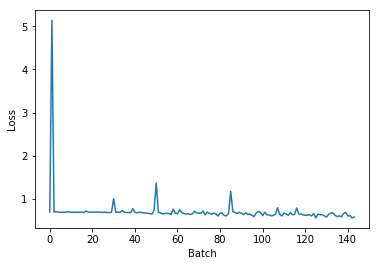

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

yy = history.losses
xx = range(len(yy))
ax.plot(xx,yy)
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
plt.show()

In [10]:
y_predicted = modelA.predict(X_test)

In [12]:
print("Predicted:")
print("Zeros: %d"%(np.sum(y_predicted<0.4)))
print("Not Sure: %d"%(np.sum(np.logical_and(y_predicted>0.4 , y_predicted<0.6))))
print("Ones: %d"%(np.sum(y_predicted>0.6)))
print("\n")
print("Actual:")
print("Zeros: %d"%(np.sum(y_test==0)))
print("Ones: %d"%(np.sum(y_test==1)))

Predicted:
Zeros: 247
Not Sure: 297
Ones: 456


Actual:
Zeros: 500
Ones: 500
